# Notebook 3: Analyzing VLM Generative Setting Annotations
This notebook performs text analysis on the annotation results of VLMs to describe the setting of the shot in one or two words, without defining fixed categories.

Three iterations of prompts were used, developed over time in order to refine the results. All prompts were only run once on the whole dataset.



---


Prompt 2A:

> Analyze the background of the provided image and describe the setting of the still with a single concise label, of ideally one or AT MOST two words, all in lowercase.


---


Prompt 2B:
- Added request to ignore visible text as upon review, some annotations were derived specifically based on the captions/visible text, even though the location of the shot is clearly not there

> You are an expert annotator of social media videos. The provided image is a still from a social media video. Ignore visible text overlaid in the still. Analyze the background of the provided image and describe the setting of the still with a single concise label, of ideally one or AT MOST two words, all in lowercase.



---


Prompt 2C:
- Added in data context in hopes of improving results to be closer to what is read.

> You are an expert annotator of social media videos. The provided image is a still from one of the Israel Defense Force’s TikTok videos. The video was posted between 7 October 2023 to 7 October 2024.
> Your task is to analyze the background of the provided image and classify the setting of the still with a single concise label. Ignore all visible text and captions in the image. This label should only be one or AT MOST two words. Return it in all lower case.
> What is the setting of the image?



In [12]:
# Initialize libraries
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np
import umap
import seaborn as sns
from wordcloud import WordCloud

In [3]:
df_scene = pd.read_csv('')
df_scene

,id,url,from_dataset,start_frame,start_time,start_fps,end_frame,end_time,end_fps,scene_num,...,setting,shot_scale_vlm_1b_01,shot_scale_vlm_1b_02,shot_scale_vlm_1b_03,location_vlm_2a_01,location_vlm_2b_01,location_vlm_2c_01,shot_scale_vlm_1a_01,shot_scale_vlm_1a_02,shot_scale_vlm_1a_03
0,7357772207445134608.mp4_scene_1,7357772207445134608,3d0ad485936bf3a6518f8633d15848b8,0,0 days 00:00:00,30.00,61,0 days 00:00:02.033000,30.00,1,...,Indoors,Medium Close Up,Medium Close Up,Medium Close Up,blue screen,blue screen,military base,MCU,MCU,MCU
1,7357772207445134608.mp4_scene_2,7357772207445134608,3d0ad485936bf3a6518f8633d15848b8,61,0 days 00:00:02.033000,30.00,83,0 days 00:00:02.767000,30.00,2,...,Outdoors,Wide Shot,Uncertain,Uncertain,night sky,urban night,night sky,WS,WS,WS
2,7357772207445134608.mp4_scene_3,7357772207445134608,3d0ad485936bf3a6518f8633d15848b8,83,0 days 00:00:02.767000,30.00,121,0 days 00:00:04.033000,30.00,3,...,Indoors,Uncertain,Uncertain,Uncertain,dark text on black,dark room,military base,Empty,Empty,Empty
3,7357772207445134608.mp4_scene_4,7357772207445134608,3d0ad485936bf3a6518f8633d15848b8,121,0 days 00:00:04.033000,30.00,221,0 days 00:00:07.367000,30.00,4,...,Indoors,Medium Close Up,Close Up,Close Up,interview setting,blue screen,military interview,MCU,MCU,MCU
4,7357772207445134608.mp4_scene_5,7357772207445134608,3d0ad485936bf3a6518f8633d15848b8,221,0 days 00:00:07.367000,30.00,229,0 days 00:00:07.633000,30.00,5,...,Indoors,Empty,Empty,Empty,black screen,black screen,black screen,Empty,Empty,Empty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1437,7287823285566426369.mp4_scene_12,7287823285566426369,3d0ad485936bf3a6518f8633d15848b8,708,0 days 00:00:23.624000,29.97,760,0 days 00:00:25.359000,29.97,12,...,Outdoors,Wide Shot,Medium Shot,Medium Shot,military operation,military operation,military operation,WS,WS,WS
1438,7287823285566426369.mp4_scene_13,7287823285566426369,3d0ad485936bf3a6518f8633d15848b8,760,0 days 00:00:25.359000,29.97,793,0 days 00:00:26.460000,29.97,13,...,Indoors,Medium Shot,Medium Shot,Medium Shot,shooting range,indoor shooting range,indoor hangar,MCU,MCU,MCU
1439,7287823285566426369.mp4_scene_14,7287823285566426369,3d0ad485936bf3a6518f8633d15848b8,793,0 days 00:00:26.460000,29.97,854,0 days 00:00:28.495000,29.97,14,...,Outdoors,Medium Shot,Medium Shot,Medium Shot,icebreaker ship,ice field,ice field,MCU,MCU,MCU
1440,7287823285566426369.mp4_scene_15,7287823285566426369,3d0ad485936bf3a6518f8633d15848b8,854,0 days 00:00:28.495000,29.97,1212,0 days 00:00:40.440000,29.97,15,...,Outdoors,Medium Close Up,Close Up,Close Up,press conference,press conference,military press conference,MCU,MCU,MCU


In [5]:
# Review locations generated, sorted by plurality
df_scene['location_vlm_2a_01'].value_counts()

,count
location_vlm_2a_01,
military base,211
desert,68
outdoor park,41
military training,39
blue screen,37
...,...
political commentary,1
political inquiry,1
dockyard,1


In [6]:
df_scene['location_vlm_2b_01'].value_counts()

,count
location_vlm_2b_01,
military base,176
outdoor park,69
urban street,41
blue screen,38
living room,36
...,...
abandoned parking lot,1
field at dusk,1
desert launch,1


In [7]:
df_scene['location_vlm_2c_01'].value_counts()

,count
location_vlm_2c_01,
military base,432
outdoor park,51
outdoor forest,44
urban street,33
desert terrain,33
...,...
military briefing room,1
home interview,1
sky defense,1


While it does appear that 2C has drastically more "military base", there is a generally a similar diversity of locations capturing similar items.

## Reviewing through word cloud
One way we can review this is through a word cloud

In [16]:
# Join the list of locations into a single string
def create_word_cloud(df, column_name, output_path):
    location_list = df[column_name].tolist()
    text = " ".join(location_list)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word cloud of VLM-generated location labels for "{column_name}"')
    plt.axis("off")
    plt.savefig(output_path)
    plt.show()

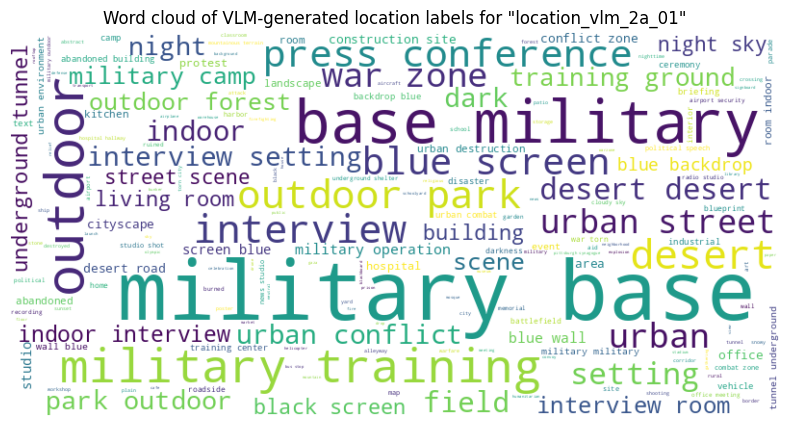

In [17]:
create_word_cloud(df=df_scene,
                  column_name='location_vlm_2a_01',
                  output_path='')

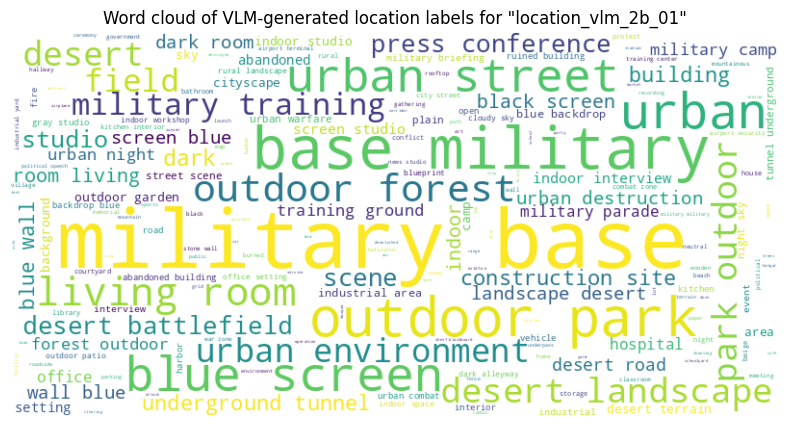

In [18]:
create_word_cloud(df=df_scene,
                  column_name='location_vlm_2b_01',
                  output_path='')

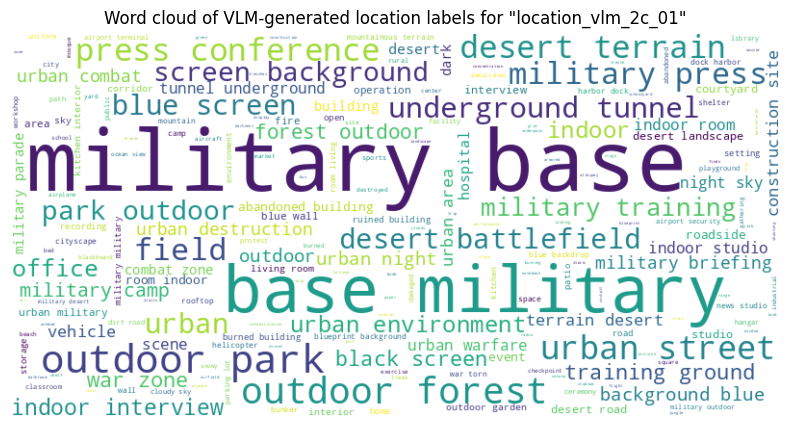

In [19]:
create_word_cloud(df=df_scene,
                  column_name='location_vlm_2c_01',
                  output_path='')

## Word Embedding clustering
Next we can use a text similarity model, namely [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) from Sentence Transformers (Reimers and Gurevych 2019) to generate word embeddings and cluster semantically similar labels together.

In [28]:
def cluster_labels(df, column_name, output_path):

    label_list = df[column_name].unique().tolist() # Option whether to obtain unique labels or not; Unique creates alot more noise
    value_counts = df[column_name].value_counts()
    # Create a list of sizes corresponding to the unique labels
    sizes = [value_counts[label] for label in label_list]

    # Load model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(label_list)

    # Clustering with kmeans
    k = 3
    clusterer = KMeans(n_clusters=k, random_state=42)
    cluster_labels = clusterer.fit_predict(embeddings)

    # Dimensionality reduction for visualization
    reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='cosine')
    embedding_2d = reducer.fit_transform(embeddings)

    # Plotting
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        embedding_2d[:, 0], embedding_2d[:, 1],
        c=cluster_labels, cmap='Set2', s=sizes
    )

    # Add a legend for the dot sizes
    legend_elements = []
    size_thresholds = [1, 10, 30, 100]  # Define thresholds for legend

    # Create legend handles for different size ranges
    for threshold in size_thresholds:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                        label=f'≥ {threshold}',
                                        markerfacecolor='gray', markersize=(np.sqrt(threshold))+2))


    plt.legend(handles=legend_elements, title="Count in scenes", loc="upper left")

    # Annotate each point with the original label; Differentiated by value_count
    for label, count in value_counts.items():
        i = label_list.index(label)
        if count > 30:
            plt.annotate(label, (embedding_2d[i, 0], embedding_2d[i, 1]), fontsize=8, alpha=0.7)
        elif 30 > count > 10:
            plt.annotate(label, (embedding_2d[i, 0], embedding_2d[i, 1]), fontsize=5, alpha=0.5)
        else:
            plt.annotate(label, (embedding_2d[i, 0], embedding_2d[i, 1]), fontsize=3, alpha=0.3)

    plt.title(f"Semantic Clustering of VLM-Generated Setting Labels for {column_name}")
    # plt.xlabel("UMAP Dimension 1")
    # plt.ylabel("UMAP Dimension 2")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.savefig(output_path)
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


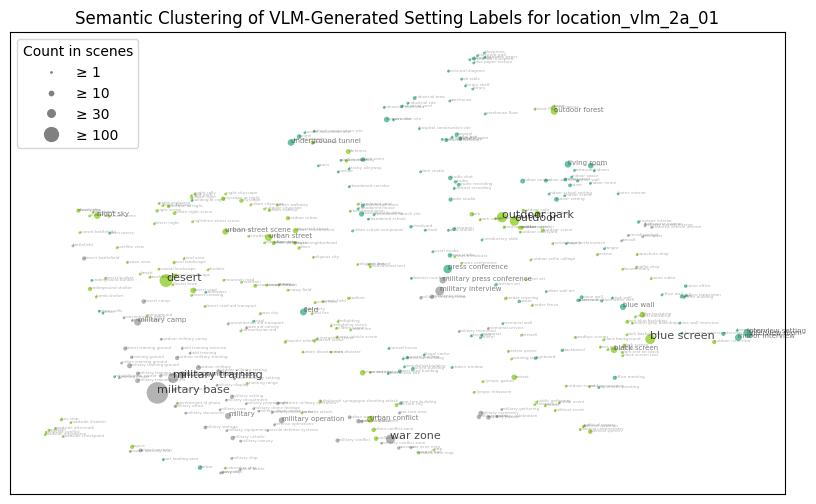

In [29]:
cluster_labels(df_scene,'location_vlm_2a_01','')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-28-505794581>:57: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path)
<ipython-input-28-505794581>:57: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path)
<ipython-input-28-505794581>:57: UserWarning: Glyph 22330 (\N{CJK UNIFIED IDEOGRAPH-573A}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from 

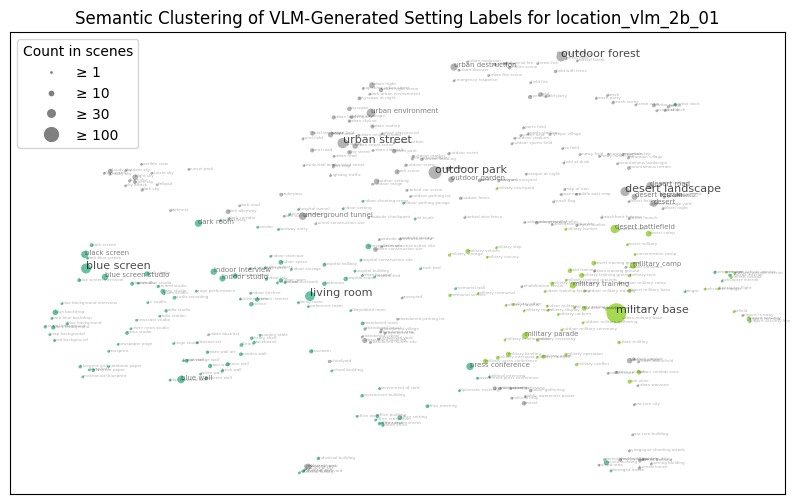

In [30]:
cluster_labels(df_scene,'location_vlm_2b_01','')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


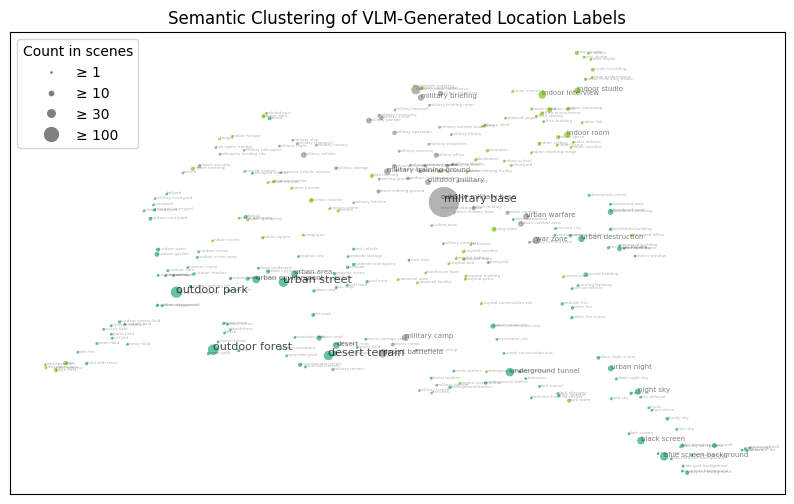

In [ ]:
cluster_labels(df_scene,'location_vlm_2c_01','')

Viewing the clustering results and word clouds from each prompt iteration provided a good overview of the key locations featured in the dataset. This overview process only required time to run the prompts (approximately 3 hours each). Using the clustering results from 2C, I developed the following five location categories. "Graphics" was used as a catch-all for any non-live action or indiscernible footage.

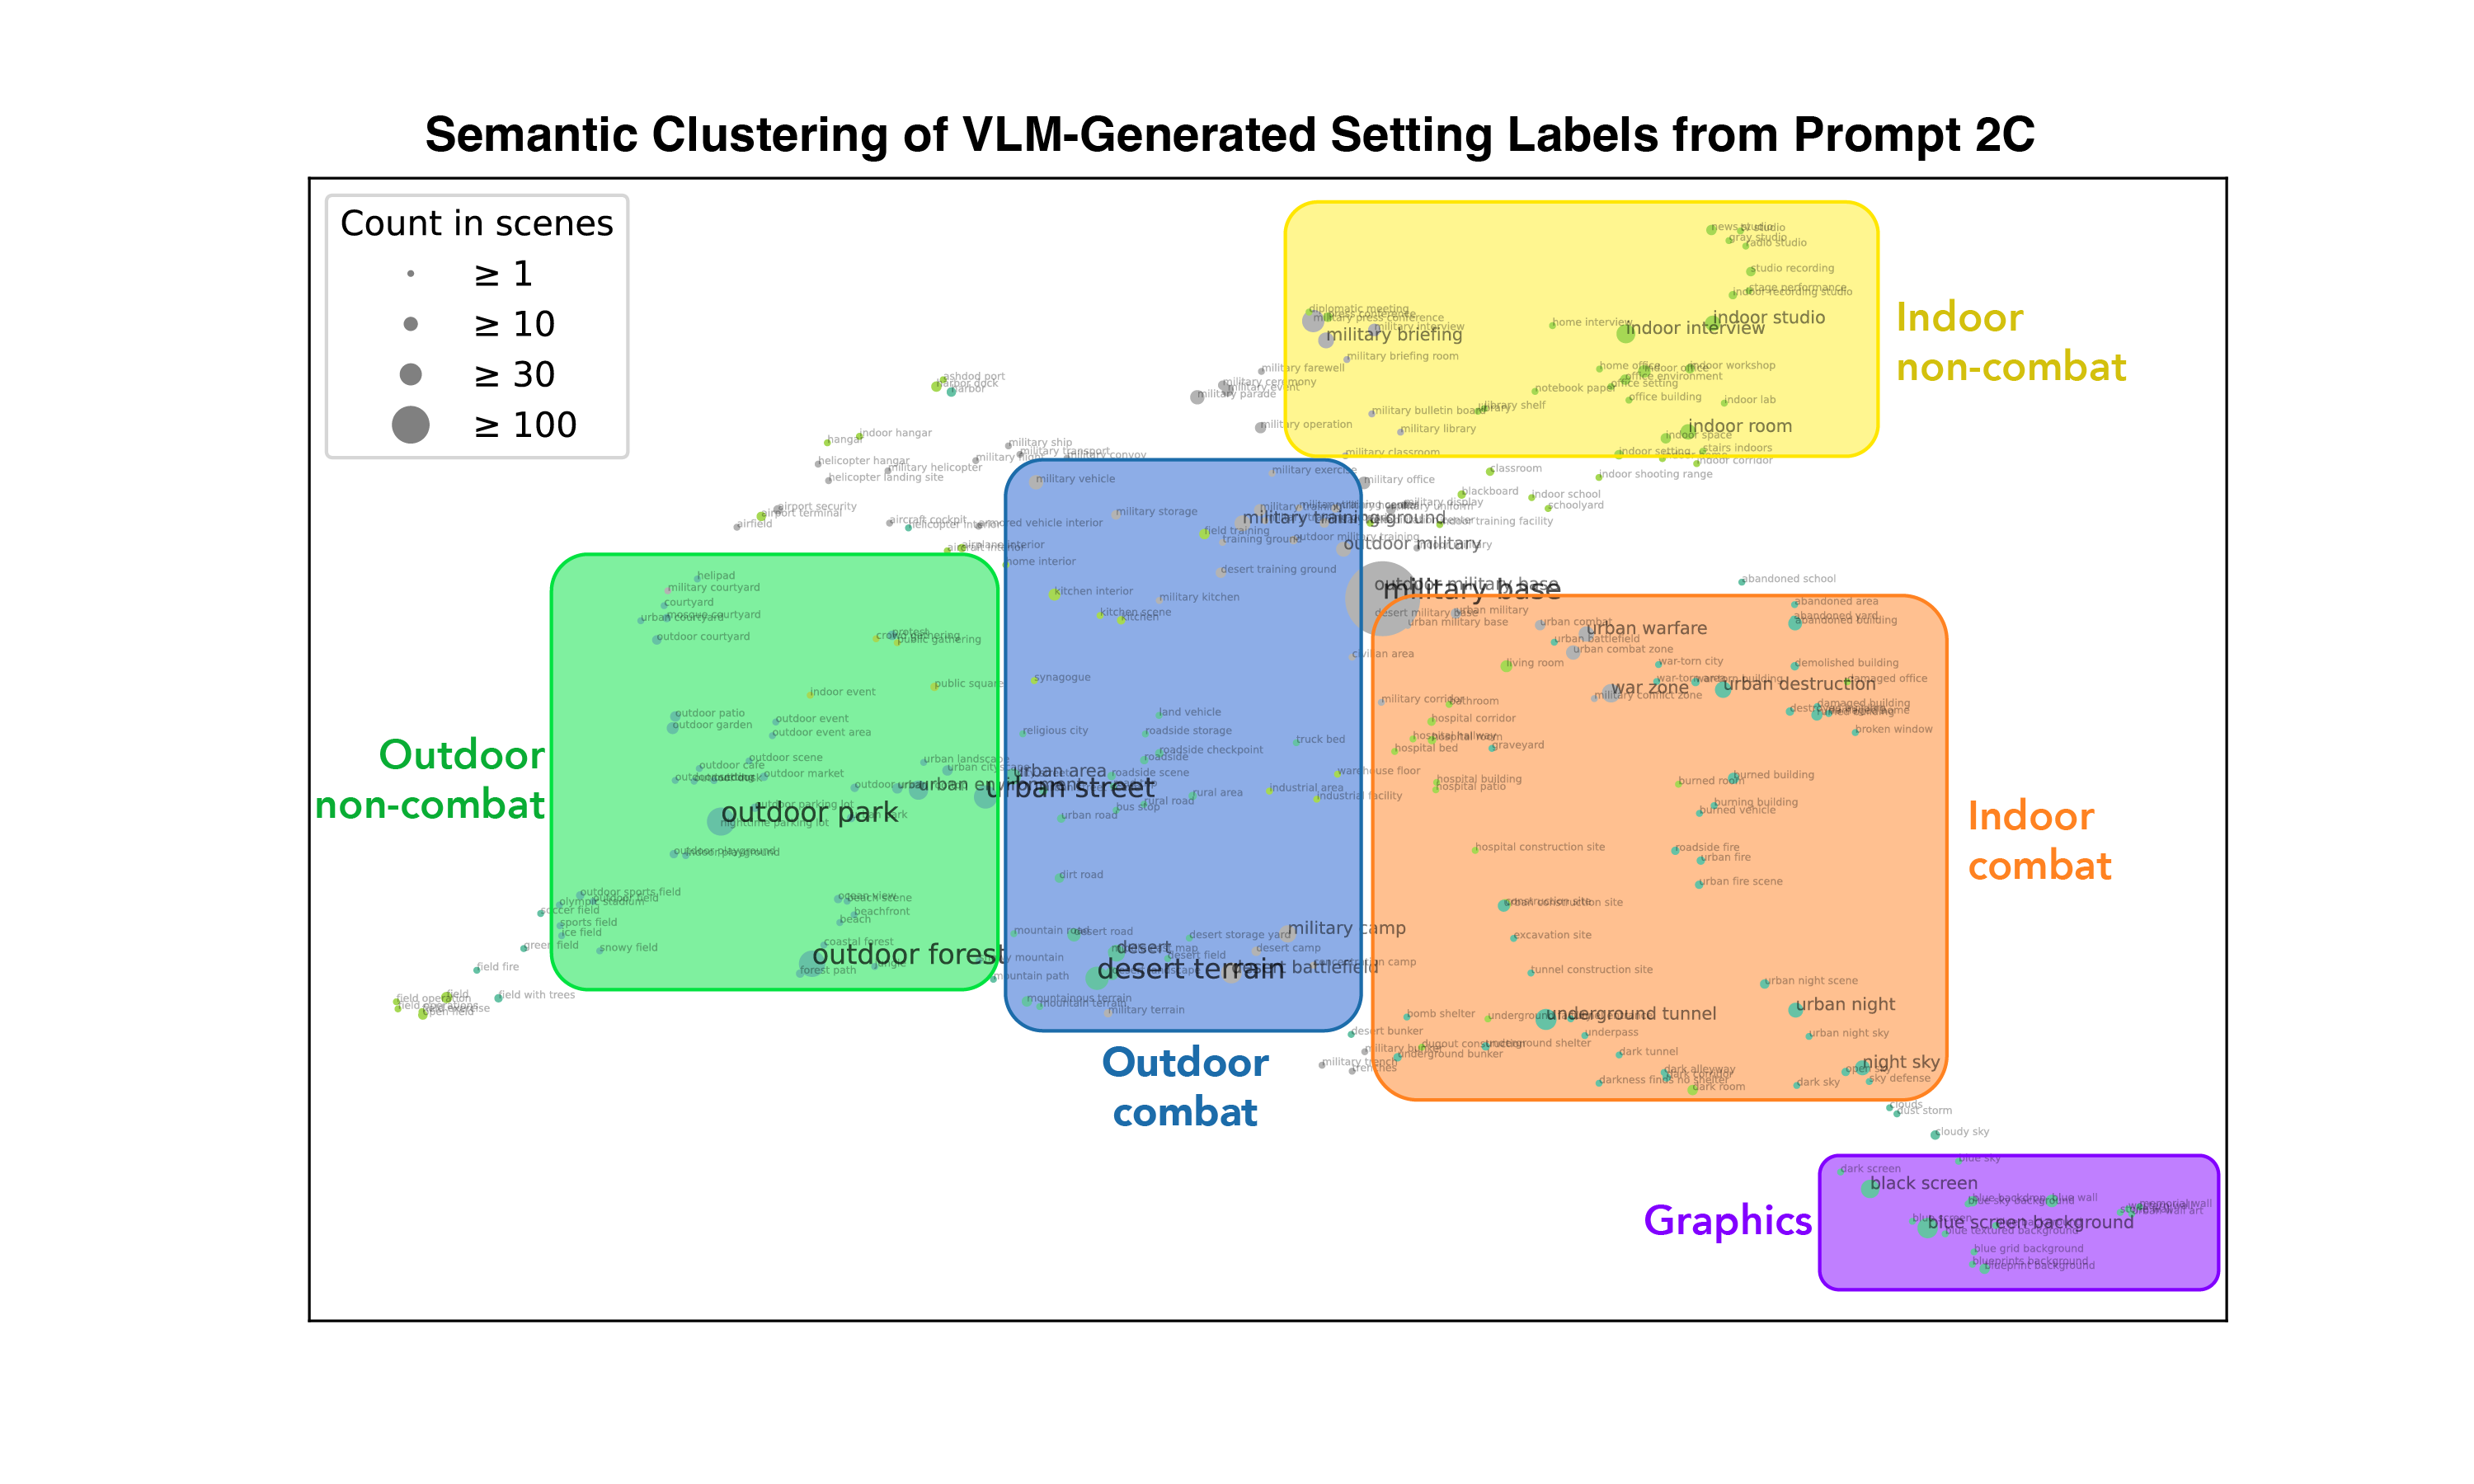

### Bonus: Not selecting for unique labels in the list
One could also treat each label as a unique item in the cluster map. However, this leads to an incredibly messy cluster map that is borderline illegible.



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Fallin

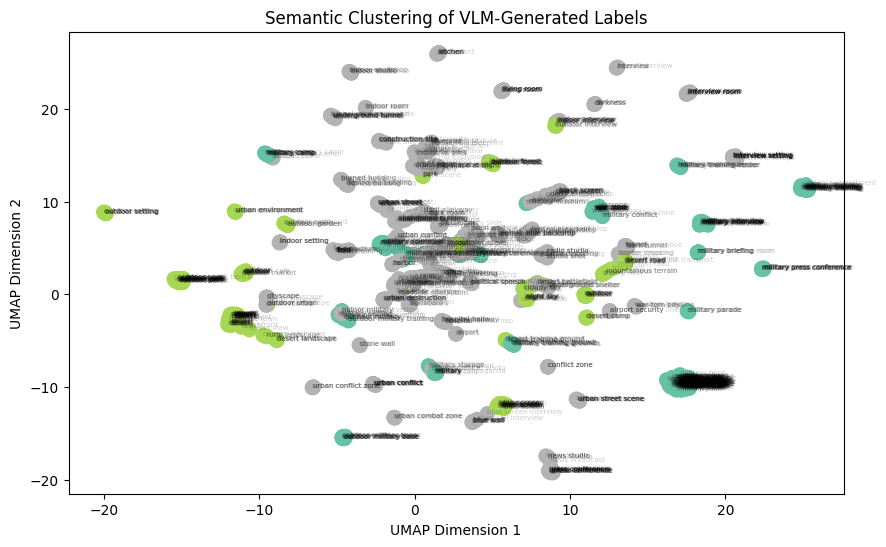

In [ ]:
# What not selecting unique looks like
# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(location_list)

# Clustering (e.g., KMeans)
k = 3
clusterer = KMeans(n_clusters=k, random_state=42)
cluster_labels = clusterer.fit_predict(embeddings)

# Dimensionality reduction for visualization
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='cosine')
embedding_2d = reducer.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1],
    c=cluster_labels, cmap='Set2', s=100
)

# Annotate each point with the original label
for i, label in enumerate(location_list):
    plt.annotate(label, (embedding_2d[i, 0], embedding_2d[i, 1]), fontsize=5, alpha=0.2)

plt.title("Semantic Clustering of VLM-Generated Labels")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(False)
plt.savefig('')
plt.show()